<a href="https://colab.research.google.com/github/dawg-at-irya/histograms-and-KDEs/blob/master/KDE_vs_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
try:
  from scipy.stats import norm
except:
  !pip install scipy
  from scipy.stats import norm

try:
  from sklearn.model_selection import GridSearchCV
  from sklearn.neighbors import KernelDensity
except:
  !pip install sklearn
  from sklearn.model_selection import GridSearchCV
  from sklearn.neighbors import KernelDensity

import numpy as np
import matplotlib.pyplot as plt

# Motivation
>#### Real data is drawn from an underlying probability distribution function (PDF) that is typically unknown to us. We only have access to a finite number of samples (data points) from this distribution. We have to use this finite sample to infer the underlying true PDF.
---
>#### To do this, we construct a *sampling distribution* using the data.
>#### In this notebook, we will look at two *nonparametric* methods to do this -- histograms and kernel density estimates.



In [89]:
# Generate some one-dimensional data.
# We will draw N samples from a Gaussian with mean 0 and standard deviation 1.
N = 10
data = norm.rvs(size=N, random_state=1001) # random_state set to ensure reproducibility

In [90]:
# Generate a plotting grid
x_grid = np.linspace(-3, 3, 1000)

# Histograms
---
## A histogram splits the data range into bins, and shows the total (`density=False`) or relative (`density=True`) number of data points inside each bin.

>>#### The histogram for our dataset shows that there are 3 points in the first bin, and then 1 or 0 points in the remaining bins. The default bin width chosen by `np.histogram` for this dataset is the distance between the minimum and maximum data values divided by the number of data points: `bin width = (data.max() - data.min()) / len(data)` $\approx$ 0.31.
>>#### The *probability mass* inside the a bin is $\displaystyle{\textrm{number of points in bin}\over \textrm{bin width}\times\textrm{total number of data points}}$

Default bin size chosen by np.histogram = 0.319
(data.max() - data.min()) / len(data) = 0.319


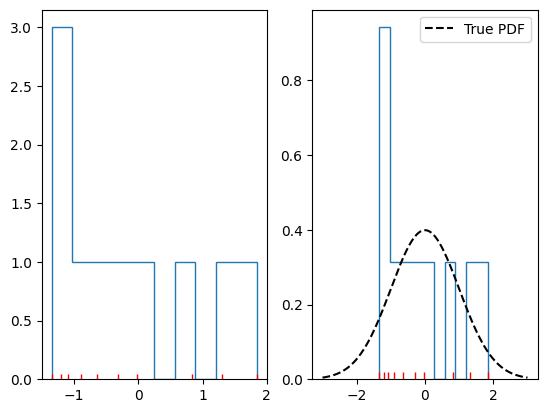

In [91]:
# Compute a histogram for these data
# Also plot the locations of the actual data points (this is called a "rug plot")
plt.figure()
plt.subplot(121)
counts, bins = np.histogram(data, density=False)
print("Default bin size chosen by np.histogram = {}".format(np.round(np.diff(bins, 1)[0], decimals=3)))
print("(data.max() - data.min()) / len(data) = {}".format(np.round((data.max() - data.min()) / len(data), decimals=3)))
_ = plt.stairs(counts, bins)
plt.plot(data, [0.01] * N, '|', color='r')
plt.subplot(122)
counts, bins = np.histogram(data, density=True)
_ = plt.stairs(counts, bins)
plt.plot(x_grid, norm.pdf(x_grid), '--', label = 'True PDF', color = 'k')
plt.legend(loc = 'best')
plt.plot(data, [0.01] * N, '|', color='r')

# Dependence of histogram bin widths and bin locations
#### We can force `np.histogram` to use user-specified bins, therefore setting not just the **bin width** but also the **locations**. This is done using the `bins` and `range` keywords.

Text(0.5, 1.0, 'Effect of bin size')

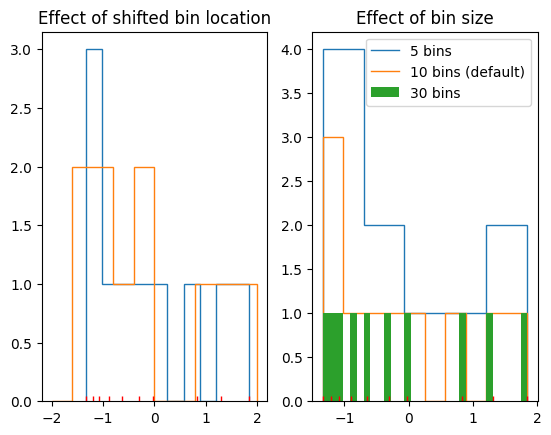

In [92]:
# Compute a histogram for these data
c1, b1 = np.histogram(data, density=False)
c2, b2 = np.histogram(data, bins=len(b1) - 1, range=(-2, 2), density=False)
c3, b3 = np.histogram(data, bins=30, density=False)
c4, b4 = np.histogram(data, bins=5, density=False)
plt.figure()
plt.subplot(121)
_ = plt.stairs(c1, b1, label='{} bins (default)'.format(len(b1) - 1))
_ = plt.stairs(c2, b2, label='{} bins (default) with shifted bin location'.format(len(b2) - 1))
plt.plot(data, [0.01] * N, '|', color='r')
plt.title('Effect of shifted bin location')
plt.subplot(122)
_ = plt.stairs(c4, b4, label='5 bins')
_ = plt.stairs(c1, b1, label='{} bins (default)'.format(len(b1) - 1))
_ = plt.stairs(c3, b3, fill=True, label='30 bins')
plt.plot(data, [0.01] * N, '|', color='r')
plt.legend(loc='best')
plt.title('Effect of bin size')

#### In the left plot, changing the location of the edge of the first bin (the "starting point") has changed the shape of the sampling distribution significantly! In the right plot, changing the number of bins (and therefore the bin width, as the range is kept fixed) also has a significant effect on the resulting distribution shape.
---
## Too many bins result in a *noisy/fluctuating* distribution, and too few bins result in *loss of detail*.
#### `np.histogram` offers ways to determine the optimal bin width and location for the given dataset. See [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) and [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges).


# Histogram as a naïve example of a kernel density estimate
#### A histogram can be thought of as consisting of two components: the raw data convolved with a *rectangular (top hat) kernel*. In computing a histogram, we are implicitly assuming that the probability density is *constant* everywhere inside a given bin (hence a top hat function, which has constant value inside the bin and zero value outside). We are using the kernel to *smear out* or *spread out* the influence of each data point over the entire width of the bin.
#### The "influence" of each data point is then $\begin{align}
\begin{cases} \displaystyle{1\over\textrm{bin width}\times\textrm{total number of data points}} & \text{data point is inside bin} \\
&\\
0 & \text{otherwise} \end{cases}
\end{align}$
#### The total "influence" in each bin is then: $\displaystyle{\textrm{number of data points inside bin}\over\textrm{bin width}\times\textrm{total number of data points}}$
---
# Why histograms can be bad sometimes
* Erases information about raw data -- location of the "rectangle" is independent of the location of the data points inside the bin.
* For small samples, the rectangular kernel introduces *granularity* which makes it difficult to infer the true PDF.
* Dependence on bin width and location, especially for small samples.
### Alternative: choose (a) smoother kernel and (b) kernels centred on each data point.

# Kernel density estimate (KDE)
>#### Convolve each data point with a smooth kernel with specified extent ("bandwidth", how far the "influence" spreads) and shape (how the "influence" fades as a function of distance from the data point).
>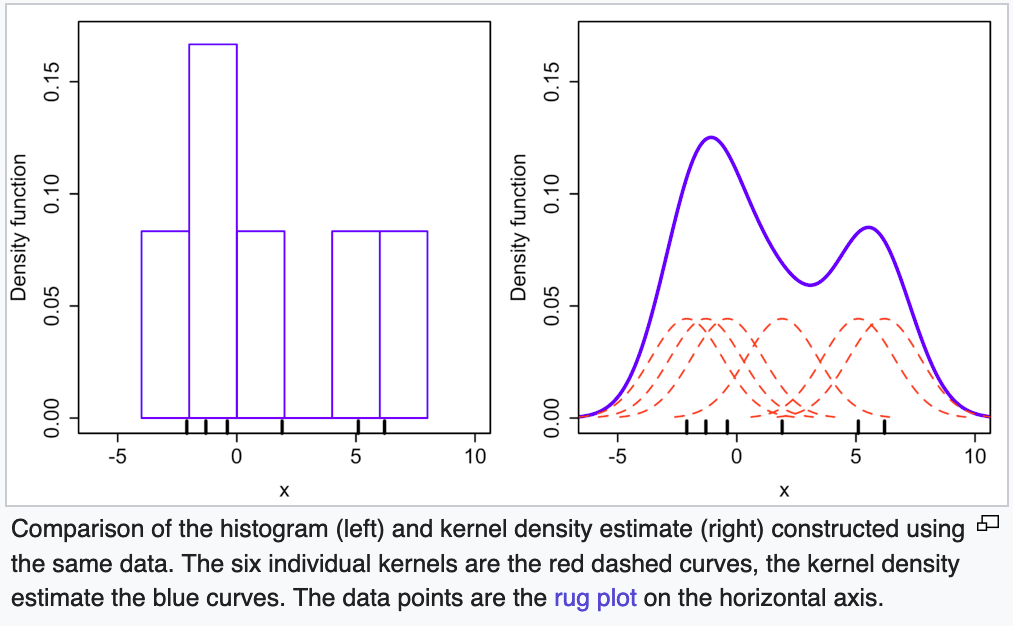
>> ###### Credit: Drleft/Wikipedia CC BY-SA 3.0

In [101]:
# Compute a KDE with a Gaussian kernel (shape) with the default bandwidth (size)
kde_auto = KernelDensity(kernel='gaussian')
kde_auto.fit(data.reshape(-1, 1))
print("The default bandwidth is {}.".format(kde_auto.bandwidth))

The default bandwidth is 1.0.


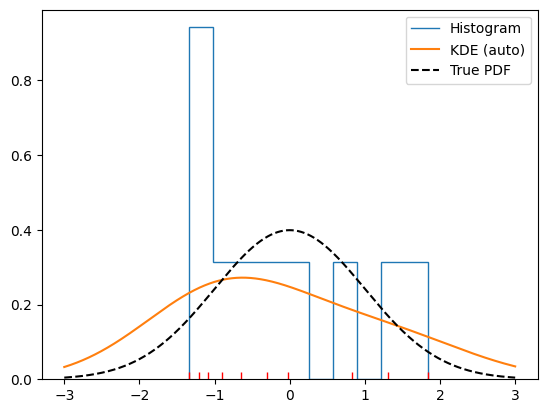

In [110]:
# Evaluate the density estimate on a grid of points
x_grid = np.linspace(-3, 3, 1000)
log_density_auto = kde_auto.score_samples(x_grid.reshape(-1, 1))

# Compare the histogram to the density estimate
plt.stairs(counts, bins, label='Histogram')
plt.plot(x_grid, np.exp(log_density_auto), label='KDE (auto)')
plt.plot(x_grid, norm.pdf(x_grid), '--', label='True PDF', color = 'k')
plt.plot(data, [0.01] * N, '|', color='r')
plt.legend(loc='best')
plt.show()

#### The resulting KDE is already a better representation of the true PDF than the histogram!

# Choice of kernel shape
>#### There are many kernel shapes to choose from (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html)). The default kernels are typically either the Gaussian or parabolic ("Epanechnikov"). For most purposes, you will not need anything different.
# Choice of bandwidth
>#### The "ideal" bandwidth for your data can be determined in many ways. One such way is to use *cross-validation*, a very popular technique in statistics and data science to determine how well a model computed for one dataset will apply to others.
>#### In what follows, we will compute a KDE with the default bandwidth and compare it to the KDE computed using the "best" bandwidth found from cross-validation.

In [102]:
# Define the range of hyperparameters to test
param_grid = {'bandwidth': np.linspace(0.1, 1.0, 30)}
# Create a grid search object
grid = GridSearchCV(KernelDensity(), param_grid, cv=10)
# Fit the grid search object to the data
grid.fit(data.reshape(-1, 1))
# Get the best hyperparameters
best_bandwidth = grid.best_params_['bandwidth']
print("The best bandwidth from grid-search CV is {}.".format(best_bandwidth))

# Compute the kernel density estimate with the best hyperparameters
kde_cv = KernelDensity(bandwidth=best_bandwidth, kernel='gaussian')
kde_cv.fit(data.reshape(-1, 1))


The best bandwidth from grid-search CV is 0.6275862068965516.


KernelDensity(bandwidth=0.6275862068965516)

#### Let us compare the results of cross validation with the default bandwidth value.

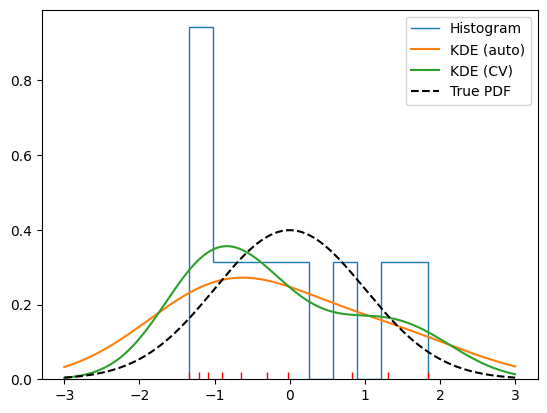

In [111]:
# Evaluate the density estimate on a grid of points
x_grid = np.linspace(-3, 3, 1000)
log_density_auto = kde_auto.score_samples(x_grid.reshape(-1, 1))
log_density_cv = kde_cv.score_samples(x_grid.reshape(-1, 1))

# Compare the histogram to the density estimate
plt.stairs(counts, bins, label='Histogram')
plt.plot(x_grid, np.exp(log_density_auto), label='KDE (auto)')
plt.plot(x_grid, np.exp(log_density_cv), label='KDE (CV)')
plt.plot(x_grid, norm.pdf(x_grid), '--', label='True PDF', color = 'k')
plt.plot(data, [0.01] * N, '|', color='r')
plt.legend(loc='best')
plt.show()

#### The cross-validated version is able to adjust the bandwidth (new value 0.68 < default value 1.0, so the "influence" of each data point is over a narrower range) such that we can see a "dip" in the KDE corresponding to the lack of data near `x=0`.

# Comparing histograms to KDEs for small and large samples
>#### We will now compare the histogram to the KDE for N = 10, 20, and 200 samples.

The default bandwidth is 1.0.
The best bandwidth from grid-search CV is 0.63.


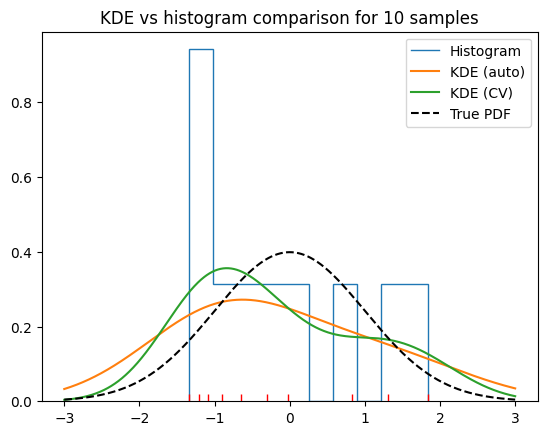

The default bandwidth is 1.0.
The best bandwidth from grid-search CV is 0.44.


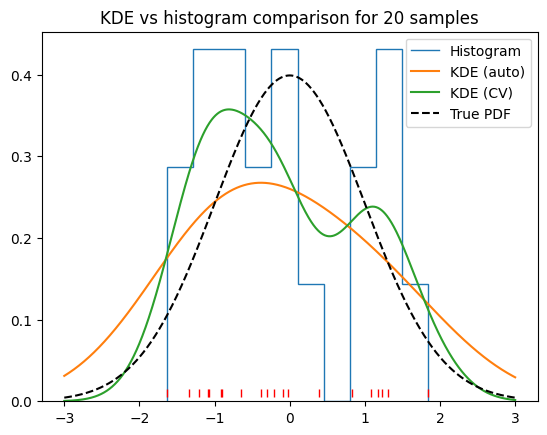

The default bandwidth is 1.0.
The best bandwidth from grid-search CV is 0.38.


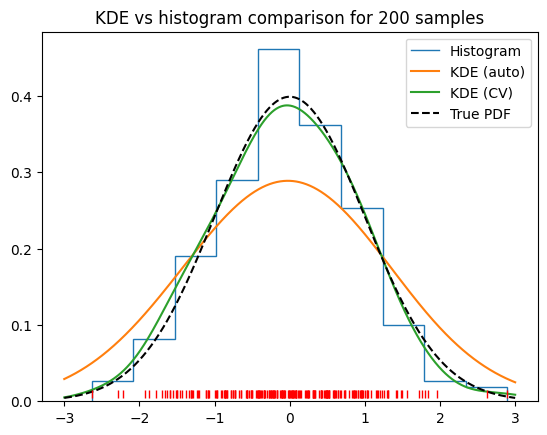

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

def KDE_vs_hist(n_samples=10):
 # Generate some one-dimensional data
 data = norm.rvs(size=n_samples, random_state=1001)
 
 # Compute a histogram for these data
 counts, bins = np.histogram(data, density=True)
 
 # Compute a KDE with the default bandwidth (1.0)
 kde_auto = KernelDensity(kernel='gaussian')
 kde_auto.fit(data.reshape(-1, 1))
 print("The default bandwidth is {}.".format(kde_auto.bandwidth))
 
 # Define the range of hyperparameters to test
 param_grid = {'bandwidth': np.linspace(0.1, 1.0, 30)}
 # Create a grid search object
 grid = GridSearchCV(KernelDensity(), param_grid, cv=10)
 # Fit the grid search object to the data
 grid.fit(data.reshape(-1, 1))
 # Get the best hyperparameters
 best_bandwidth = grid.best_params_['bandwidth']
 print("The best bandwidth from grid-search CV is {}.".format(np.round(best_bandwidth, decimals=2)))
 
 # Compute the kernel density estimate with the best hyperparameters
 kde_cv = KernelDensity(bandwidth=best_bandwidth, kernel='gaussian')
 kde_cv.fit(data.reshape(-1, 1))

 # Evaluate the density estimate on a grid of points
 x_grid = np.linspace(-3, 3, 1000)
 log_density_auto = kde_auto.score_samples(x_grid.reshape(-1, 1))
 log_density_cv = kde_cv.score_samples(x_grid.reshape(-1, 1))

 # Compare the histogram to the density estimate
 plt.stairs(counts, bins, label='Histogram')
 plt.plot(x_grid, np.exp(log_density_auto), label='KDE (auto)')
 plt.plot(x_grid, np.exp(log_density_cv), label='KDE (CV)')
 plt.plot(x_grid, norm.pdf(x_grid), '--', label='True PDF', color = 'k')
 plt.plot(data, [0.01] * n_samples, '|', color='r')
 plt.title('KDE vs histogram comparison for {} samples'.format(n_samples))
 plt.legend(loc='best')
 plt.show()

KDE_vs_hist(n_samples=10)
KDE_vs_hist(n_samples=20)
KDE_vs_hist(n_samples=200)

>#### As N increases, the histogram is less affected by outliers and becomes more centrally concentrated (due to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem))
>#### In fact, for large N the histogram approaches the true PDF faster than the default KDE.
>#### However, the CV-based KDE does a better job than the histogram.

# Notes
>#### 1. What happens if you change to a rectangular kernel with a small bandwidth?
>>#### Try it! Change `kde_auto = KernelDensity(kernel='gaussian')` to `kde_auto = KernelDensity(kernel='tophat', bandwidth=0.28)` in the above code and see how the plots change.
>#### 2. Look up the documentation for `sklearn.neighbors.KernelDensity` to learn more uses!
>#### 3. The KDE is EVEN BETTER for 2D data! See [here](https://stackoverflow.com/questions/41577705/how-does-2d-kernel-density-estimation-in-python-sklearn-work), for example. Good news for blobologists!